In [22]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

plt.style.use('ggplot')

import nltk 


In [23]:
#read in data 
df = pd.read_csv('../input/amazon-fine-food-reviews/Reviews.csv')
print(df.shape)
df = df.head(500)
print(df.shape)


(568454, 10)
(500, 10)


In [24]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


##QUICK EDA 


Text(0.5, 0, 'Review Stars')

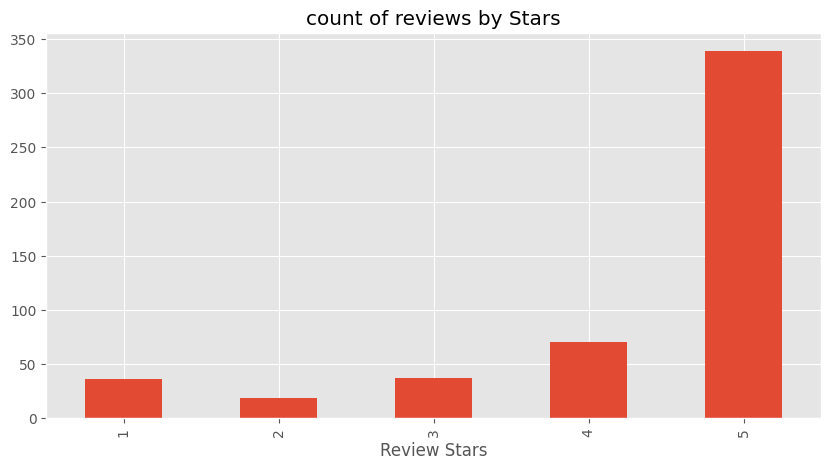

In [25]:
ax = df['Score'].value_counts().sort_index() \
    .plot(kind='bar', 
          title='count of reviews by Stars',
          figsize=(10,5))
ax.set_xlabel('Review Stars')

Basic NLTK 

In [26]:
example = df['Text'][60]
print(example)

Watch your prices with this.  While the assortment was good, and I did get this on a gold box purchase, the price for this was<br />$3-4 less at Target.


In [27]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['Watch',
 'your',
 'prices',
 'with',
 'this',
 '.',
 'While',
 'the',
 'assortment',
 'was']

In [28]:
tagged = nltk.pos_tag(tokens)

In [29]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  Watch/VB
  your/PRP$
  prices/NNS
  with/IN
  this/DT
  ./.
  While/IN
  the/DT
  assortment/NN
  was/VBD
  good/JJ
  ,/,
  and/CC
  I/PRP
  did/VBD
  get/VB
  this/DT
  on/IN
  a/DT
  gold/NN
  box/NN
  purchase/NN
  ,/,
  the/DT
  price/NN
  for/IN
  this/DT
  was/VBD
  </JJ
  br/NN
  //NNP
  >/NNP
  $/$
  3-4/JJ
  less/NN
  at/IN
  (ORGANIZATION Target/NNP)
  ./.)


# Step 1 Vader Sentiment Scoring 


# **Roberta Pretrained Model****



this model is context related 


In [30]:
from transformers import AutoTokenizer 
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax 
from tqdm import tqdm
from nltk.sentiment import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()


In [31]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


In [32]:
# Run on Roberta Model 

encoded_text = tokenizer(example, return_tensors= 'pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)


{'roberta_neg': 0.014716559, 'roberta_neu': 0.27715138, 'roberta_pos': 0.708132}


In [33]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors= 'pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
  }
    return scores_dict


In [34]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
  try:
    text = row['Text']
    myid = row['Id']
    vader_result = sia.polarity_scores(text)

    roberta_result = polarity_scores_roberta(text)
    both = {**vader_result, **roberta_result}
    res[myid] = both 
  except RuntimeError:
     print(f'Broke for id{myid}')

 17%|█▋        | 84/500 [00:10<00:35, 11.65it/s]

Broke for id83


 37%|███▋      | 186/500 [00:21<00:35,  8.84it/s]

Broke for id187


100%|██████████| 500/500 [01:00<00:00,  8.23it/s]


In [35]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns = {'index' :'Id'})
results_df = results_df.merge(df, how= 'left')

In [36]:
results_df.columns


Index(['Id', 'neg', 'neu', 'pos', 'compound', 'roberta_neg', 'roberta_neu',
       'roberta_pos', 'ProductId', 'UserId', 'ProfileName',
       'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time',
       'Summary', 'Text'],
      dtype='object')

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

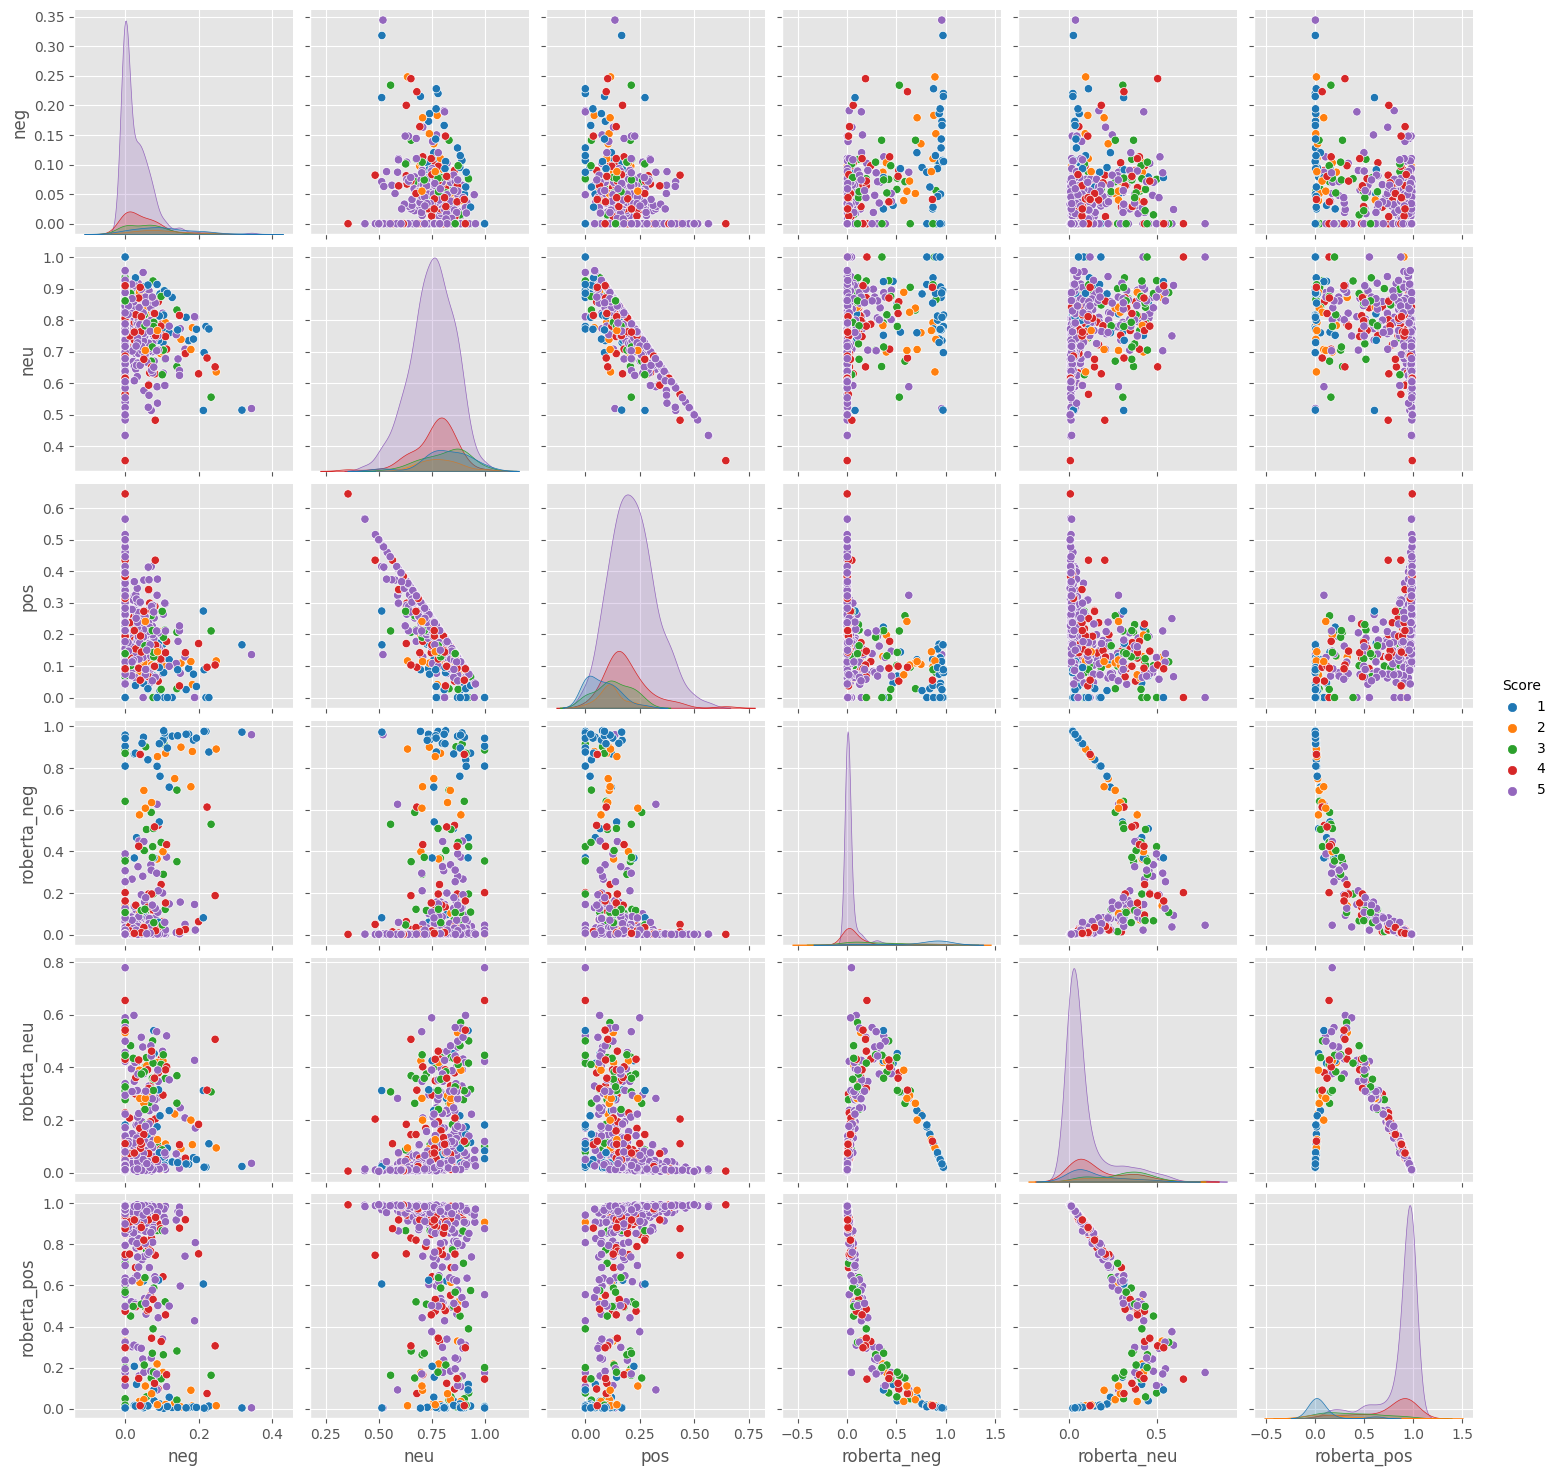

In [37]:
sns.pairplot(data= results_df, 
             vars=['neg','neu','pos','roberta_neg','roberta_neu','roberta_pos'],
             hue= 'Score',
             palette= 'tab10'
            )
plt.show()

 17%|█▋        | 84/500 [00:09<00:36, 11.26it/s]

Broke for id83


 37%|███▋      | 186/500 [00:21<00:34,  9.09it/s]

Broke for id187


100%|██████████| 500/500 [01:01<00:00,  8.18it/s]


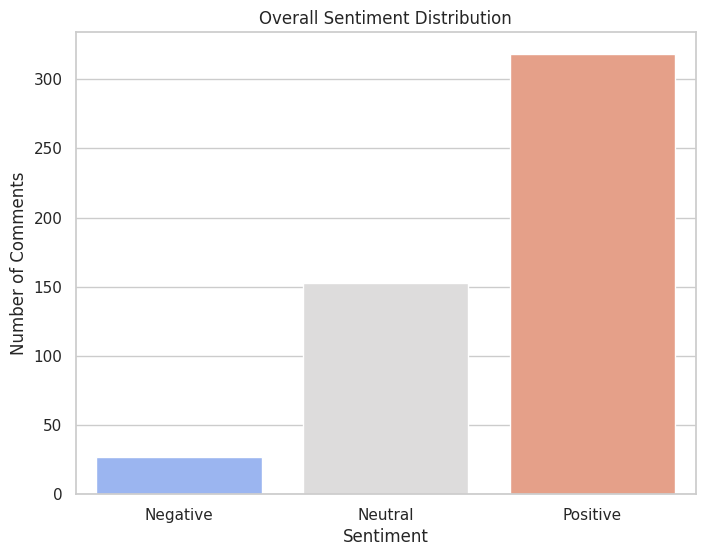

In [45]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# Your existing function for polarity scores
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        vader_result = sia.polarity_scores(text)
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id{myid}')

# Store the polarity results in a DataFrame
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')

# Adding the compound sentiment column based on the highest sentiment score
def get_compound_sentiment(row):
    # Create a list of sentiment scores (vader + roberta)
    vader_pos, vader_neu, vader_neg = row['pos'], row['neu'], row['neg']
    roberta_pos, roberta_neu, roberta_neg = row['roberta_pos'], row['roberta_neu'], row['roberta_neg']
    
    # Combine them (you can experiment with different logic to weight them)
    pos_score = vader_pos + roberta_pos
    neu_score = vader_neu + roberta_neu
    neg_score = vader_neg + roberta_neg
    
    # Return the compound sentiment based on the highest score
    if pos_score > neu_score and pos_score > neg_score:
        return 2  # Positive
    elif neg_score > neu_score:
        return 0  # Negative
    else:
        return 1  # Neutral

# Apply the function to create a new column for overall sentiment
results_df['Compound_Sentiment'] = results_df.apply(get_compound_sentiment, axis=1)

# Visualize the overall sentiment distribution with a simple count plot
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.countplot(x='Compound_Sentiment', data=results_df, palette='coolwarm')
plt.title("Overall Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Number of Comments")
plt.xticks(ticks=[0, 1, 2], labels=['Negative', 'Neutral', 'Positive'])
plt.show()


the extracted keywords from the DataFrame 


In [38]:
def extract_keywords_from_df(df, text_column='Text', top_n=10):
    import re
    import nltk
    from collections import Counter
    from sklearn.feature_extraction.text import TfidfVectorizer

    nltk.download('stopwords')
    from nltk.corpus import stopwords

    # 1. Load basic and custom stopwords
    default_stopwords = set(stopwords.words('english'))

    # ✅ FIX: Fixed indentation for custom_stopwords
    custom_stopwords = {
        # Generic HTML and common noise
        "br", "nbsp", "http", "https", "com", "www", "amp",

        # Generic opinions
        "good", "great", "nice", "bad", "worst", "best", "awesome", "amazing",
        "love", "hate", "like", "dislike", "okay", "ok", "perfect", "fine", "excellent",

        # Empty modifiers and fillers
        "just", "really", "very", "so", "too", "quite", "pretty", "much", "little", "bit",
        "thing", "something", "anything", "everything", "nothing", "lot",

        # User behavior / neutral verbs
        "got", "get", "gets", "getting", "gotten", "go", "went", "going", "come", "came", "buy",
        "bought", "use", "used", "using", "make", "made", "makes", "put", "take", "took",
        "say", "said", "see", "seen", "look", "looked", "looks", "feel", "felt",

        # Generic pronouns / structure words
        "one", "two", "three", "thing", "something", "anything", "everything", "nothing",
        "i", "me", "my", "mine", "you", "your", "we", "us", "our", "they", "them", "their", "he", "she", "it", "its",
        "this", "that", "these", "those", "there", "here",

        # Time references
        "day", "week", "month", "year", "time", "first", "last", "always", "never", "sometimes", "often", "soon", "now",

        # Modal and linking verbs
        "can", "could", "should", "would", "will", "won't", "don't", "does", "did", "was", "were", "am", "is", "are", "be", "been", "being", "have", "has", "had",

        # Product generic words
        "product", "item", "thing", "stuff", "package", "order", "amazon", "review", "brand", "buy", "purchased",
        "delivery", "shipping", "price", "quality", "value", "customer", "service",

        # Generic food-related terms
        "taste", "flavor", "food", "snack", "drink", "chip", "chips", "eating", "eat", "edible"
    }

    # ✅ FIX: convert the union set to a list (required by TfidfVectorizer)
    all_stopwords = list(default_stopwords.union(custom_stopwords))

    # 2. Gather text from DataFrame
    comments = df[text_column].dropna().astype(str).tolist()
    text = " ".join(comments)
    words = re.findall(r'\b\w+\b', text.lower())

    # 3. Filter out stopwords
    filtered_words = [word for word in words if word not in all_stopwords]

    # 4. Frequency count
    word_counts = Counter(filtered_words)
    most_common_words = word_counts.most_common(top_n)

    # 5. TF-IDF
    vectorizer = TfidfVectorizer(stop_words=all_stopwords, max_features=top_n)  # ✅ all_stopwords is now a list
    tfidf_matrix = vectorizer.fit_transform(comments)
    feature_names = vectorizer.get_feature_names_out()

    return {
        "most_common_words": most_common_words,
        "keywords": feature_names.tolist()
    }


In [46]:
import pandas as pd
import spacy
from collections import Counter

def extract_opinion_phrases_df(df, text_column='Text', top_n=30):
    nlp = spacy.load("en_core_web_sm")
    comments = df[text_column].dropna().astype(str).tolist()
    all_phrases = []

    # Generic or non-informative nouns and verbs to exclude
    generic_nouns = {
        "thing", "stuff", "brand", "item", "product", "store", "shop", "place", 
        "area", "site", "company", "website"
    }

    generic_verbs = {
        "buy", "purchase", "get", "found", "see", "use", "order", "pay", "make", "try"
    }

    for comment in comments:
        doc = nlp(comment)

        for token in doc:
            # ADJ + NOUN (e.g., good quality)
         if token.pos_ == "ADJ" and token.head.pos_ == "NOUN":
            if token.dep_ == "amod" and token.head.pos_ == "NOUN":
                if (
                    not token.is_stop 
                    and not token.head.is_stop 
                    and len(token.text) > 2 
                    and token.head.lemma_.lower() not in generic_nouns
                ):
                    phrase = f"{token.text.lower()} {token.head.text.lower()}"
                    all_phrases.append(phrase)

            # VERB + NOUN (e.g., love flavor)
            elif token.pos_ == "VERB" and token.head.pos_ == "NOUN":
                if (
                    not token.is_stop 
                    and not token.head.is_stop 
                    and len(token.text) > 2 
                    and token.head.lemma_.lower() not in generic_nouns 
                    and token.lemma_.lower() not in generic_verbs
                ):
                    phrase = f"{token.text.lower()} {token.head.text.lower()}"
                    all_phrases.append(phrase)

    phrase_counts = Counter(all_phrases).most_common(top_n)
    return pd.DataFrame(phrase_counts, columns=['Phrase', 'Count'])


In [47]:
phrases_df = extract_opinion_phrases_df(df)
print(phrases_df.to_string(index=False))


/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


         Phrase  Count
   good quality      7
       dry food      7
   great flavor      7
      hot sauce      6
    good flavor      6
    gummy bears      5
      green tea      5
    great price      4
    great taste      4
  free shipping      4
natural balance      4
      long time      4
     sour cream      4
      black tea      4
     past years      4
      good chip      4
 favorite chips      4
instant oatmeal      3
        low fat      3
    brown sugar      3
   high quality      3
     little bit      3
   limited food      3
      hot spots      3
       old food      3
     spicy food      3
   small pieces      3
     larger bag      3
    fresh fruit      3
     great deal      3
